In [1]:
import os
import sys

In [2]:
cur_root_dir = os.getcwd()
print("Current root dir is {}".format(cur_root_dir))
if cur_root_dir not in sys.path:
    sys.path.append(cur_root_dir)

Current root dir is /home/rafaelpossas/dev/bayes_sim


In [3]:
from src.models.MDN import MDNN, MDRFF
from src.models.BayesSim import BayesSim
from src.data.FrankaDataGenerator import FrankaDataGenerator
from src.utils.param_inference import *
import pickle
import numpy as np
import matplotlib.pyplot as plt


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


# Inference on Franka Panda Stiffness Parameter

### Loading simulation data from file

The FrankaDataGenerator is responsible for running the forward model with priors sampled from an uniform distribution with the believed range of the actual values. As our simulator is expensive to run, we save the results to a file in advance so don't need to run the forward model everytime we want to recover posteriors

In order to collect data we assume:
    - There is a controller/policy of which you can run your forward model (simulation) with.
    - You are able to calculate some sufficient statistics from your trajectories. In our case we use a Reinforcement Learning policy that we calculate cross-correlation
    - You have some understanding of the prior parameters of your simulation. For instance, you know that a specific parameter can't go below or over some threshold

In [4]:
data_file = os.path.join(os.path.join(cur_root_dir, "assets/data_stiffness_5k.pkl"))

In [5]:
g = FrankaDataGenerator(data_file=data_file, load_from_disk=True, params_dim=1, data_dim=154)
params, stats = g.gen(1)
shapes = {"params": params.shape[1], "data": stats.shape[1]}
print("Total data size: {}".format(g.total_size))

Total data size: 5000


### Training the model using a Mixture of Density network

We train a mixture of density network / mixture of density random fourier features where the inputs are the sufficient statistics calculated from the data and the output are the weights, means and variances of the Mixture of Gaussians

Training model....

*********************************  End  *********************************

Duration: 0:00:38.263346


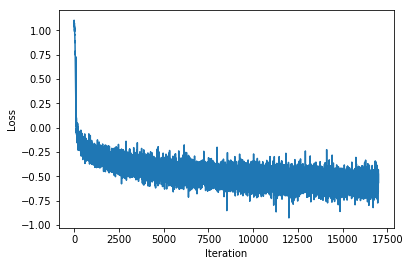

In [6]:
log_mdn, inf_mdn = train(epochs=500, batch_size=150, generator=g, model="MDN")

### Training the Model using a Mixture of Density Random Fourier Features


*********************************  End  *********************************

Duration: 0:00:28.739164


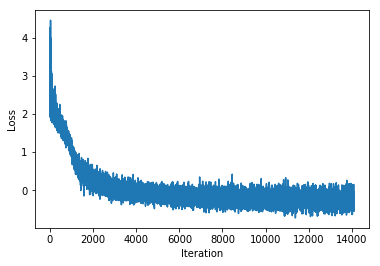

In [7]:
log_rff, inf_rff = train(epochs=100, batch_size=500, generator=g, model="MDRFF")

### Recovering the posterior from a specific stiffness parameter

Now you can either run an experiment in the real robot or collect trajectories for a specific value of your dynamics parameter. You can then input the sufficient statistics of these trajectories in Bayes Sim and it will recover your full posterior over the chosen parameter

### MDN

Scaled true obs: [[0.12002482]]
Params: [0.11985698]


*********************************  Prediction ends  *********************************


Duration: 0:00:00.127101
component 1: mixture weight = 0.8157; mean = 0.1360; variance = 0.0045
component 2: mixture weight = 0.1843; mean = 0.4972; variance = 0.0438


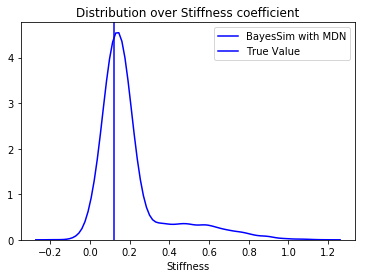

In [18]:
true_obs = np.array([[6000]])
get_results_from_true_obs(true_obs, generator=g, inf=inf_mdn, shapes=shapes, param_name="Stiffness", model_name="MDN")

Scaled true obs: [[0.80029381]]
Params: [0.80052525]


*********************************  Prediction ends  *********************************


Duration: 0:00:00.000651
component 1: mixture weight = 0.0439; mean = 0.8818; variance = 0.1329
component 2: mixture weight = 0.9561; mean = 0.8546; variance = 0.0237


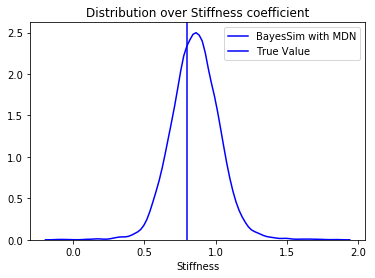

In [19]:
true_obs = np.array([[40000]])
get_results_from_true_obs(true_obs, generator=g, inf=inf_mdn, shapes=shapes, param_name="Stiffness", model_name="MDN")

### MDRFF

Scaled true obs: [[0.12002482]]
Params: [0.11985698]


*********************************  Prediction ends  *********************************


Duration: 0:00:00.001238
component 1: mixture weight = 0.9510; mean = 0.2748; variance = 0.0320
component 2: mixture weight = 0.0490; mean = -0.1823; variance = 0.0077


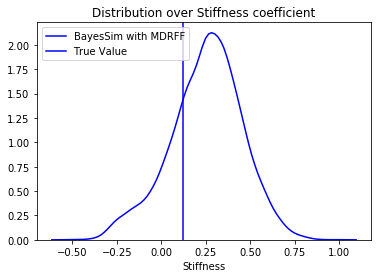

In [20]:
true_obs = np.array([[6000]])
get_results_from_true_obs(true_obs, generator=g, inf=inf_rff, shapes=shapes, param_name="Stiffness", model_name="MDRFF")

Scaled true obs: [[0.80029381]]
Params: [0.80052525]


*********************************  Prediction ends  *********************************


Duration: 0:00:00.001303
component 1: mixture weight = 0.2454; mean = 0.7088; variance = 0.0409
component 2: mixture weight = 0.7546; mean = 0.8161; variance = 0.0031


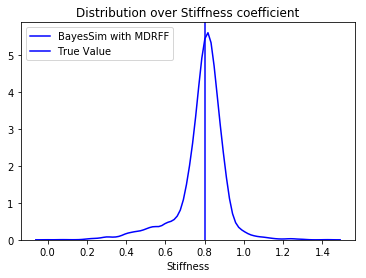

In [21]:
true_obs = np.array([[40000]])
get_results_from_true_obs(true_obs, generator=g, inf=inf_rff, shapes=shapes, param_name="Stiffness", model_name="MDRFF")